In [10]:
import sklearn.metrics
import pandas as pd
import numpy as np 
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
from hpsklearn import estimator, components
%matplotlib inline
from hyperopt import tpe
import fonctions_auxiliaires

In [21]:
data = pd.read_csv('Kaggle_YourCabs_training.csv',delimiter=',')
score = pd.read_csv('Kaggle_YourCabs_score.csv',delimiter=',')

In [3]:
y = data['Car_Cancellation']
COE = data['Cost_of_error']

del data['Car_Cancellation']
del data['Cost_of_error']
del data['id']

data.columns = data.columns.str.replace('from_date','from_date_date')
data.columns = data.columns.str.replace('booking_created','booking_created_date')

data['from_date_hour'] = None
data['booking_created_hour'] = None

In [4]:
for index in data.index : 
    
    if(index%5000 == 0) :
        print(index)
    
    fdd , fdh = data.loc[index]['from_date_date'].split(' ')
    bcd , bch =  data.loc[index]['booking_created_date'].split(' ')
    
    data.set_value(index=index, col='from_date_date' , value=fdd)
    data.set_value(index=index, col='from_date_hour' , value=fdh)
    
    data.set_value(index=index, col='booking_created_date' , value=bcd)
    data.set_value(index=index, col='booking_created_hour' , value=bch)    

0
5000
10000
15000
20000
25000
30000
35000
40000


In [5]:
del score['Unnamed: 18']
del score['Unnamed: 19']
del score['id']

score.columns = score.columns.str.replace('from_date','from_date_date')
score.columns = score.columns.str.replace('booking_created','booking_created_date')

score['from_date_hour'] = None
score['booking_created_hour'] = None

In [6]:
for index in score.index : 
    
    if(index%5000 == 0) :
        print(index)
    
    fdd , fdh = score.loc[index]['from_date_date'].split(' ')
    bcd , bch =  score.loc[index]['booking_created_date'].split(' ')
    
    score.set_value(index=index, col='from_date_date' , value=fdd)
    score.set_value(index=index, col='from_date_hour' , value=fdh)
    
    score.set_value(index=index, col='booking_created_date' , value=bcd)
    score.set_value(index=index, col='booking_created_hour' , value=bch)    

0
5000


In [7]:
le_fdd = LabelEncoder()
le_bcd = LabelEncoder()
le_fdh = LabelEncoder()
le_bch = LabelEncoder()

data.from_date_date = le_fdd.fit_transform(data.from_date_date)
data.from_date_hour = le_fdh.fit_transform(data.from_date_hour)
data.booking_created_date = le_bcd.fit_transform(data.booking_created_date)
data.booking_created_hour = le_bch.fit_transform(data.booking_created_hour)

score.from_date_date = le_fdd.fit_transform(score.from_date_date)
score.from_date_hour = le_fdh.fit_transform(score.from_date_hour)
score.booking_created_date = le_bcd.fit_transform(score.booking_created_date)
score.booking_created_hour = le_bch.fit_transform(score.booking_created_hour)

In [8]:
data.set_index(['user_id']).to_csv('Cab-training.csv')

** CV **

In [9]:
class_1 = set(y[y==1].index)
class_0 = set(y[y==0].index)
train_set_indices = set()
test_set_indices = set()

In [10]:
for element in class_0 :    
    if (np.random.uniform(0, 1) > 0.2) : 
        train_set_indices.add(element)
    else : 
        test_set_indices.add(element)
        
for element in class_1 :    
    if (np.random.uniform(0, 1) > 0.2) : 
        train_set_indices.add(element)
    else : 
        test_set_indices.add(element)   

In [11]:
X_train = data.loc[train_set_indices]
X_test = data.loc[test_set_indices]

y_train  = y.loc[train_set_indices]
y_test = y.loc[test_set_indices]

In [12]:
X_train = X_train.fillna(0)

** AUTOML **

In [22]:
estim = estimator.hyperopt_estimator(classifier=components.any_classifier('clf'),algo=tpe.suggest, \
                                    fit_increment =1, fit_increment_dump_filename='cab_logfile')

In [23]:
estim.fit(np.ascontiguousarray(X_train),np.ascontiguousarray(y_train))

In [24]:
print(estim.score(X_train, y_train))

0.927838311819


In [25]:
X_test = X_test.fillna(0)

In [26]:
print(estim.score(X_test, y_test))

0.928075855689


In [27]:
y = estim.predict(X_test)
confusion_m = confusion_matrix(y_true=y_test, y_pred = y)

In [93]:
precision = confusion_m[0,0]/(confusion_m[0,0] + confusion_m[1,0])
recall = confusion_m[0,0] /(confusion_m[0,0] + confusion_m[0,1])

In [28]:
metrics_cab = fonctions_auxiliaires.metrics(estim, X_train, y_train, X_test, y_test, y)

In [94]:
print(precision, recall)

0.930005737235 0.996802361333


In [95]:
F  = 2*(precision*recall)/(precision+recall)

In [96]:
F

0.96224623055918324

In [97]:
estim.best_model()

{'ex_preprocs': (),
 'learner': KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='euclidean',
            metric_params=None, n_jobs=1, n_neighbors=42, p=2,
            weights='distance'),
 'preprocs': (MinMaxScaler(copy=True, feature_range=(-1.0, 1.0)),)}

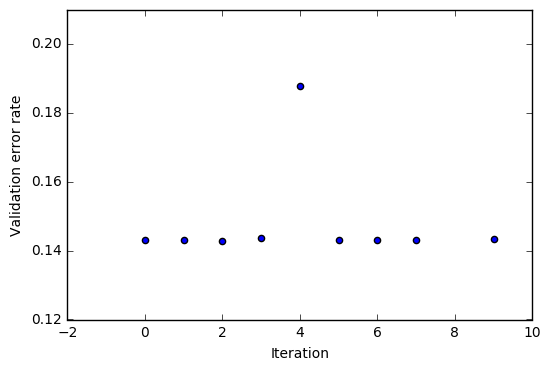

In [104]:
from hpsklearn import demo_support
import matplotlib.pyplot as plt
% matplotlib inline
fig = plt.figure()

ax= fig.add_subplot(111)
demo_support.scatter_error_vs_time(estim, ax)
#ax2 = fig.add_subplot(111)
#demo_support.plot_minvalid_vs_time(estim, ax2)

In [126]:
estim.trials.results

[{'duration': 1.4387152194976807,
  'loss': 0.1430631670031728,
  'loss_variance': 1.7682979554333634e-05,
  'status': 'ok'},
 {'duration': 6.440834045410156,
  'loss': 0.1430631670031728,
  'loss_variance': 1.7682979554333634e-05,
  'status': 'ok'},
 {'duration': 54.137336015701294,
  'loss': 0.1427747331987309,
  'loss_variance': 1.7653268247333351e-05,
  'status': 'ok'},
 {'duration': 89.8244423866272,
  'loss': 0.14364003461205654,
  'loss_variance': 1.7742330170013522e-05,
  'status': 'ok'},
 {'duration': 7.18467116355896,
  'loss': 0.18777040669166423,
  'loss_variance': 2.1998078907040422e-05,
  'status': 'ok'},
 {'duration': 89.38829493522644,
  'loss': 0.1430631670031728,
  'loss_variance': 1.7682979554333634e-05,
  'status': 'ok'},
 {'duration': 1.992460012435913,
  'loss': 0.1430631670031728,
  'loss_variance': 1.7682979554333634e-05,
  'status': 'ok'},
 {'duration': 9.89268183708191,
  'loss': 0.1430631670031728,
  'loss_variance': 1.7682979554333634e-05,
  'status': 'ok'},

In [131]:
class_values = estim.trials.vals
len(class_values)

82

In [129]:
class_values['clf']

[6, 1, 1, 1, 1, 3, 5, 4, 2, 3]

In [121]:
alldata = estim.trials.trials

In [148]:
alldata[1]['misc']['vals'].values()

dict_values([[], [], [], [], [], [], [], [0], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [3], [], [], [], [], [], [], [0], [], [], [], [], [], [], [], [12.0], [], [], [], [], [], [], [], [0], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [1], [], [], [], [], [], [], [], [], [], []])

In [149]:
type(alldata[1]['book_time'])

datetime.datetime

In [11]:
fonctions_auxiliaires.plot_perf(estim)

NameError: name 'estim' is not defined